In [3]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector

In [4]:
dataset_dir = 'data/'
mat_files = sorted([file for file in os.listdir(dataset_dir) if file.endswith('.mat')])
mat_files

# Specify inspection sequence
idx = 4
mat_data = scipy.io.loadmat(os.path.join(dataset_dir, mat_files[idx]))
image_sequence = np.float32(mat_data["imageArray"])
h, w, sequence_size = image_sequence.shape[0], image_sequence.shape[1], image_sequence.shape[2]

In [5]:
from scipy.signal import medfilt

def apply_median(pixel_signal):
    return medfilt(pixel_signal, kernel_size=3)

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, 12:1612]

imageMatrix = np.apply_along_axis(apply_median, axis=1, arr=imageMatrix)

imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

In [6]:
import torch
import torch.nn as nn

class Conv1DAutoencoder(nn.Module):
    def __init__(self):
        super(Conv1DAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),     # Conv1
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=3, stride=1, padding=1),    # Conv2
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),         # Pool1

            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),    # Conv3
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1),    # Conv4
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),         # Pool2

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),    # Conv5
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),    # Conv6
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),         # Pool3

            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),    # Conv7
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),    # Conv8
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),    # Conv9
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),    # Conv10
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),                             # Upsample1
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=1, padding=1),          # Deconv1
            nn.ReLU(),

            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=1, padding=1),          # Deconv2
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),                             # Upsample2
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=1, padding=1),          # Deconv3
            nn.ReLU(),

            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=1, padding=1),          # Deconv4
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),                             # Upsample3
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=1, padding=1),          # Deconv5
            nn.ReLU(),

            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=1, padding=1),          # Deconv6
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=1, padding=1),          # Deconv7
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size=3, stride=1, padding=1),          # Deconv8
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=1, padding=1),           # Deconv9
            nn.Conv1d(1, 1, 1)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:1000]
subset_data = train_data[subset_indices]

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = Conv1DAutoencoder().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [8]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        x = batch[0].to(device)

        optimizer.zero_grad()
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 8745.772461
Epoch 10: Loss = 1667.855591
Epoch 20: Loss = 52.574394
Epoch 30: Loss = 15.936625
Epoch 40: Loss = 10.559637
Epoch 50: Loss = 10.438162
Epoch 60: Loss = 8.804542
Epoch 70: Loss = 10.109952
Epoch 80: Loss = 10.149236
Epoch 90: Loss = 8.451005


In [9]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        _, z = model(x)
        z_compressed = torch.mean(z.cpu(), dim=1)
        all_latents.append(z_compressed)
        
principal_comp = torch.cat(all_latents, dim=0).numpy()

In [10]:
pca_array = principal_comp.reshape(h, w, z_compressed.shape[-1])

pca_images = np.array([
    ((pca_array[:, :, i] - np.min(pca_array[:, :, i])) /
     (np.max(pca_array[:, :, i]) - np.min(pca_array[:, :, i]) + 1e-8))
    for i in range(z_compressed.shape[1])
])

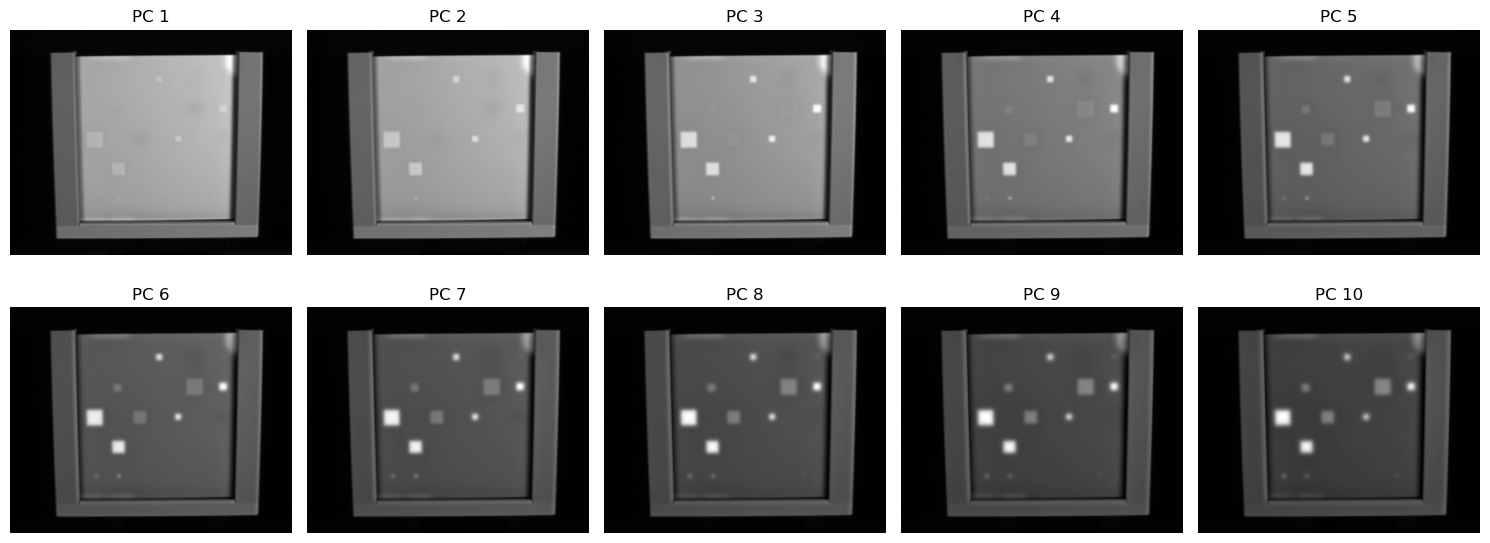

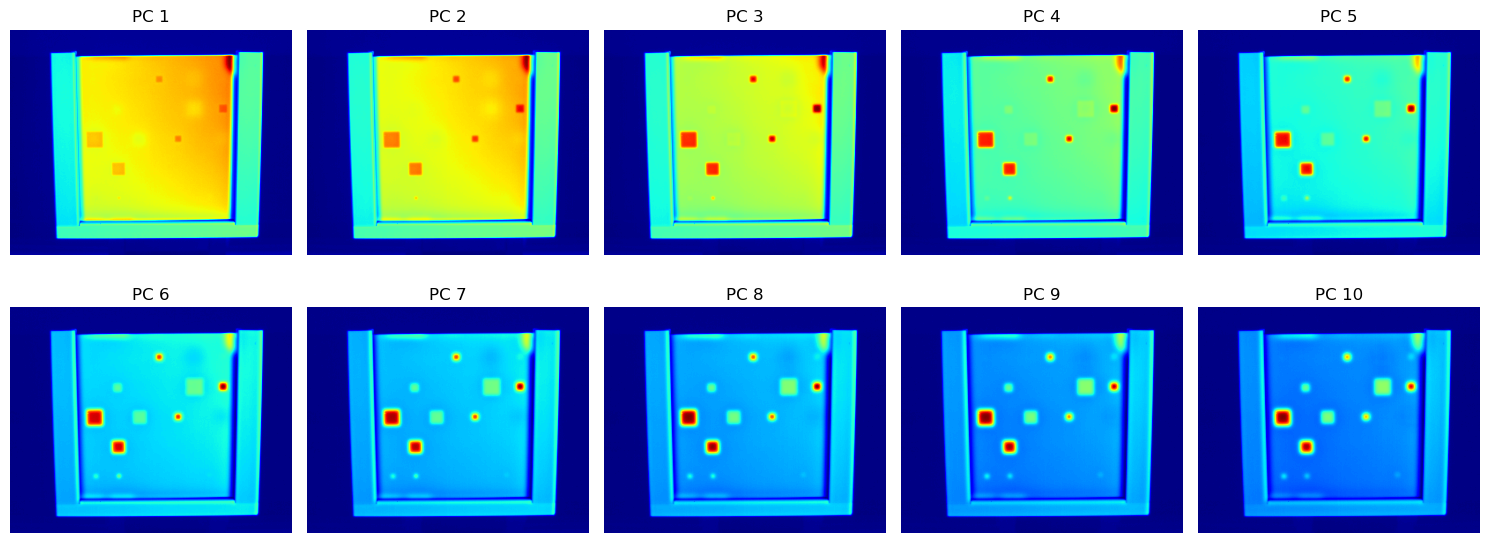

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_images[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()